In [77]:
#Importar librerías
from vivienda_cdmx.vivicdmx import lamudi,easybroker
import pandas as pd
import time
import random
from matplotlib import pyplot as plt
import folium
from folium.plugins import HeatMap,MarkerCluster
import branca
import numpy as np
import geopandas as gpd
from shapely.geometry import Point


#### Scrapeo de datos de los portales inmobiliarios

In [2]:
# Listado
portales = [ easybroker, lamudi]
# df vacía
df = pd.DataFrame()

# proceso de scrapeo
for portal in portales:
    try:
        # Tiempo de inicio
        print("Proceso iniciado a las ", time.strftime("%H:%M:%S"),"del día", time.strftime("%d/%m/%y"))
        
        # Ejecuta la función de scraping
        df_portal = portal()  
        df = pd.concat([df, df_portal])
        
        # Records
        print("Número de registros: ", len(df))
        
    except Exception as e:
        # Si ocurre un error, lo imprime
        print(f"Ocurrió un error: {e}")
    
    finally:
        
        print("Proceso terminado a las ", time.strftime("%H:%M:%S"),"del día", time.strftime("%d/%m/%y"))
        print("--------------------------------------------------")
        
        # Sleep for a random time before the next iteration
        time.sleep(random.randint(1, 3))

    
df

Proceso iniciado a las  14:31:14 del día 07/04/24


Scrapeando Easybroker: 100%|██████████| 100/100 [06:27<00:00,  3.87s/it]


Número de registros:  2385
Proceso terminado a las  14:37:41 del día 07/04/24
--------------------------------------------------
Proceso iniciado a las  14:37:44 del día 07/04/24


Scrapeando Lamudi: 100%|██████████| 100/100 [05:45<00:00,  3.45s/it]


Número de registros:  5389
Proceso terminado a las  14:44:07 del día 07/04/24
--------------------------------------------------


oferta      precio  \
0               oportunidad departamento con 2 balcones  10799999.0   
1        depa remodelado en venta cuajimalpa parte baja   4200000.0   
2     venta departamentos  narvarte  ote  icacos 545...   2755000.0   
3     venta departamentos siberia 188 pensador mexic...   1750996.0   
4     venta departamento amazonas   col. cuauhtemoc ...   4095000.0   
...                                                 ...         ...   
3001                departamento en venta en san rafael   3950000.0   
3002                    departamento en venta en sta fe  26000000.0   
3003                departamento en venta en san rafael   2300000.0   
3004                departamento en venta en del carmen   2650000.0   
3005               departamento en venta en cosmopolita   2650000.0   

      mts_const                                          direccion bathrooms  \
0         194.0           Departamento en Santa Fe, Álvaro Obregón       3.0   
1         120.0  Departamento en Cuajimalpa, Cuajimalpa de Morelos       2.0   
2          63.0    Departamento en Narvarte Oriente, Benito Juárez       2.0   
3          50.0  Departamento en Pensador Mexicano, Venustiano ...       NaN   
4          50.0           Departamento en Renacimiento, Cuauhtémoc       NaN   
...         ...                                                ...       ...   
3001       37.0                                                NaN         1   
3002      350.0                                                NaN         3   
3003       54.0                                                NaN         1   
3004      102.0                                                NaN         1   
3005       68.0                                                NaN         2   

     recamaras         lat          lon      fuente             fecha_consulta  
0          3.0  19.3471946  -99.2563456  easybroker 2024-04-07 14:37:41.870985  
1          3.0  19.3578384  -99.2928011  easybroker 2024-04-07 14:37:41.870985  
2          2.0  19.3989196  -99.1529289  easybroker 2024-04-07 14:37:41.870985  
3          NaN  19.4427831  -99.0905572  easybroker 2024-04-07 14:37:41.870985  
4          NaN  19.4356338  -99.1495107  easybroker 2024-04-07 14:37:41.870985  
...        ...         ...          ...         ...                        ...  
3001         1   19.437462   -99.161841      lamudi 2024-04-07 14:44:07.967550  
3002         3   19.361988   -99.266219      lamudi 2024-04-07 14:44:07.967550  
3003         2  19.4418924  -99.1628852      lamudi 2024-04-07 14:44:07.967550  
3004         3  19.3742407  -99.1381217      lamudi 2024-04-07 14:44:07.967550  
3005         2    19.47478    -99.16339      lamudi 2024-04-07 14:44:07.967550  

[5389 rows x 10 columns]

In [3]:
df["fuente"].unique()

array(['easybroker', 'lamudi'], dtype=object)

#### Limpieza de datos

In [43]:
#Máximos y mínimos
print(df['precio'].max(),",",df['precio'].min())
#Precio promedio
print(df['precio'].mean())
print(df['precio'].median())
print(df['precio'].std())

884811000.0 , 1.0
9071901.499261737
5661690.0
17643643.96955086


In [88]:
def limpia_datos(df):
    df = df.reset_index(drop=True)
   
    # Eliminar registros con precio 0 o nan
    df = df[df['precio'] > 0]
    df = df[df['precio'].notna()]
    #Eliminar precios menores a un millón
    df = df[df['precio'] > 1000000]
    #Elimonar registros con menos de 30 metros cuadrados
    df = df[df['mts_const'] > 30]
    # Eliminar registros sin latitud y longitud
    df = df[df['lat'].notna()]
    df = df[df['lon'].notna()]
    # Eliminar registros que en oferta contengan "terreno", "renta", "remodelar", "hectareas"
    df = df[~df['oferta'].str.contains('terreno', case=False, na=False)]
    df = df[~df['oferta'].str.contains('renta', case=False, na=False)]
    df = df[~df['oferta'].str.contains('remodelar', case=False, na=False)]
    df = df[~df['oferta'].str.contains('hectareas', case=False, na=False)]
    # Eliminar registros con misma oferta y mismo precio
    df = df.drop_duplicates(subset=['oferta', 'precio'], keep='first')

    # Calcular precio por metro cuadrado
    df['precio_m2'] = df['precio'] / df['mts_const']
    
    # Calcular el precio promedio y la desviación estándar
    precio_promedio = df['precio'].mean()
    desviacion_estandar = df['precio'].std()
    
    # Calcular límites basados en el promedio y la desviación estándar
    limite_inferior = precio_promedio - desviacion_estandar
    limite_superior = precio_promedio + desviacion_estandar
    
    # Filtrar los registros para eliminar aquellos fuera de una desviación estándar del promedio
    df = df[(df['precio'] >= limite_inferior) & (df['precio'] <= limite_superior)]
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    #Añadir alcaldía a los datos
    url="https://datos.cdmx.gob.mx/dataset/bae265a8-d1f6-4614-b399-4184bc93e027/resource/deb5c583-84e2-4e07-a706-1b3a0dbc99b0/download/limite-de-las-alcaldas.json"
    alcaldias = gpd.read_file(url)
    alcaldias.columns=alcaldias.columns.str.lower()
    #Usar crs de alcaldías
    gdf.crs = alcaldias.crs
    gdf = gpd.sjoin(gdf, alcaldias[['geometry', 'nomgeo']], how="left", predicate='within')
    gdf.drop(columns=['index_right', 'geometry'], inplace=True)  # Clean up index and geometry columns from join

    # Convert GeoDataFrame back to DataFrame
    df_final = pd.DataFrame(gdf)
    #Eliminar si nomgeo es nulo
    df_final = df_final[df_final['nomgeo'].notna()]

    return df_final


In [89]:
df_limpia=limpia_datos(df)
df_limpia

oferta      precio  \
0               oportunidad departamento con 2 balcones  10799999.0   
1        depa remodelado en venta cuajimalpa parte baja   4200000.0   
2     venta departamentos  narvarte  ote  icacos 545...   2755000.0   
3     venta departamentos siberia 188 pensador mexic...   1750996.0   
4     venta departamento amazonas   col. cuauhtemoc ...   4095000.0   
...                                                 ...         ...   
5384                departamento en venta en san rafael   3950000.0   
5385                    departamento en venta en sta fe  26000000.0   
5386                departamento en venta en san rafael   2300000.0   
5387                departamento en venta en del carmen   2650000.0   
5388               departamento en venta en cosmopolita   2650000.0   

      mts_const                                          direccion bathrooms  \
0         194.0           Departamento en Santa Fe, Álvaro Obregón       3.0   
1         120.0  Departamento en Cuajimalpa, Cuajimalpa de Morelos       2.0   
2          63.0    Departamento en Narvarte Oriente, Benito Juárez       2.0   
3          50.0  Departamento en Pensador Mexicano, Venustiano ...       NaN   
4          50.0           Departamento en Renacimiento, Cuauhtémoc       NaN   
...         ...                                                ...       ...   
5384       37.0                                                NaN         1   
5385      350.0                                                NaN         3   
5386       54.0                                                NaN         1   
5387      102.0                                                NaN         1   
5388       68.0                                                NaN         2   

     recamaras         lat          lon      fuente  \
0          3.0  19.3471946  -99.2563456  easybroker   
1          3.0  19.3578384  -99.2928011  easybroker   
2          2.0  19.3989196  -99.1529289  easybroker   
3          NaN  19.4427831  -99.0905572  easybroker   
4          NaN  19.4356338  -99.1495107  easybroker   
...        ...         ...          ...         ...   
5384         1   19.437462   -99.161841      lamudi   
5385         3   19.361988   -99.266219      lamudi   
5386         2  19.4418924  -99.1628852      lamudi   
5387         3  19.3742407  -99.1381217      lamudi   
5388         2    19.47478    -99.16339      lamudi   

                 fecha_consulta      precio_m2                 nomgeo  
0    2024-04-07 14:37:41.870985   55670.097938         Álvaro Obregón  
1    2024-04-07 14:37:41.870985   35000.000000  Cuajimalpa de Morelos  
2    2024-04-07 14:37:41.870985   43730.158730          Benito Juárez  
3    2024-04-07 14:37:41.870985   35019.920000    Venustiano Carranza  
4    2024-04-07 14:37:41.870985   81900.000000             Cuauhtémoc  
...                         ...            ...                    ...  
5384 2024-04-07 14:44:07.967550  106756.756757             Cuauhtémoc  
5385 2024-04-07 14:44:07.967550   74285.714286  Cuajimalpa de Morelos  
5386 2024-04-07 14:44:07.967550   42592.592593             Cuauhtémoc  
5387 2024-04-07 14:44:07.967550   25980.392157          Benito Juárez  
5388 2024-04-07 14:44:07.967550   38970.588235           Azcapotzalco  

[3855 rows x 12 columns]

In [90]:
df_limpia.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3855 entries, 0 to 5388
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   oferta          3855 non-null   object        
 1   precio          3855 non-null   float64       
 2   mts_const       3855 non-null   float64       
 3   direccion       1769 non-null   object        
 4   bathrooms       3408 non-null   object        
 5   recamaras       3646 non-null   object        
 6   lat             3855 non-null   object        
 7   lon             3855 non-null   object        
 8   fuente          3855 non-null   object        
 9   fecha_consulta  3855 non-null   datetime64[ns]
 10  precio_m2       3855 non-null   float64       
 11  nomgeo          3855 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 391.5+ KB


In [92]:
df_limpia['precio'].max(),df_limpia['precio'].min()


(29000000.0, 1040000.0)

### Mapa

In [93]:
url="https://datos.cdmx.gob.mx/dataset/bae265a8-d1f6-4614-b399-4184bc93e027/resource/deb5c583-84e2-4e07-a706-1b3a0dbc99b0/download/limite-de-las-alcaldas.json"

alcaldias = gpd.read_file(url)
alcaldias.columns=alcaldias.columns.str.lower()

In [122]:
mapa = folium.Map(location=[19.4326, -99.1332], zoom_start=12, 
                  tiles="http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}", 
                  attr="Google")


agg_data = df_limpia.groupby(['lat', 'lon'])['precio'].mean().reset_index(name='avg_price')


vmin_value = agg_data['avg_price'].min()
vmax_value = agg_data['avg_price'].max()

# Heatmap de precios
HeatMap(data=agg_data[['lat', 'lon', 'avg_price']], radius=9, max_zoom=20, name="Mapa de calor de precios", overlay=True, 
        control=True, show=True, gradient={0.0: 'green', 0.5: 'yellow', 1.0: 'red'}).add_to(mapa)


cmap = branca.colormap.LinearColormap(colors=['green', 'yellow', 'red'], 
                                      index=[vmin_value, (vmin_value + vmax_value) / 2, vmax_value],
                                      vmin=vmin_value, vmax=vmax_value, caption="Precio promedio")
mapa.add_child(cmap)


marker_cluster = MarkerCluster(name="Viviendas").add_to(mapa)


for i in range(len(df_limpia)):
    formatted_precio = f"{df_limpia.iloc[i]['precio']:,}"
    formatted_precio_m2 = f"{round(df_limpia.iloc[i]['precio_m2'], 2):,}"

    folium.Marker([df_limpia.iloc[i]['lat'], df_limpia.iloc[i]['lon']],
                  tooltip=folium.Tooltip(f"<b>Oferta:</b> {df_limpia.iloc[i]['oferta']}<br>"
                                         f"<b>Alcaldía:</b> {df_limpia.iloc[i]['nomgeo']}<br>"
                                         f"<b>Precio:</b> {formatted_precio}<br>"
                                         f"<b>Metros construidos:</b> {df_limpia.iloc[i]['mts_const']}<br>"
                                         f"<b>Precio por metro cuadrado:</b> {formatted_precio_m2}<br>"),
                  icon=folium.Icon(color='blue', icon='home')
                 ).add_to(marker_cluster)

#Añadir las alcaldías
folium.GeoJson(alcaldias, name="Alcaldías", style_function=lambda x: {'fillColor': 'white', 'color': '#dd1c77', 'weight': 1.5},
               tooltip=folium.features.GeoJsonTooltip(fields=['nomgeo'], aliases=['Alcaldía'])).add_to(mapa)


#Salvar el mapa
mapa.save("mapa_cdmx.html")

mapa

### Estadísticas básicas

Text(6.0, 500, 'Mediana: 5.5')

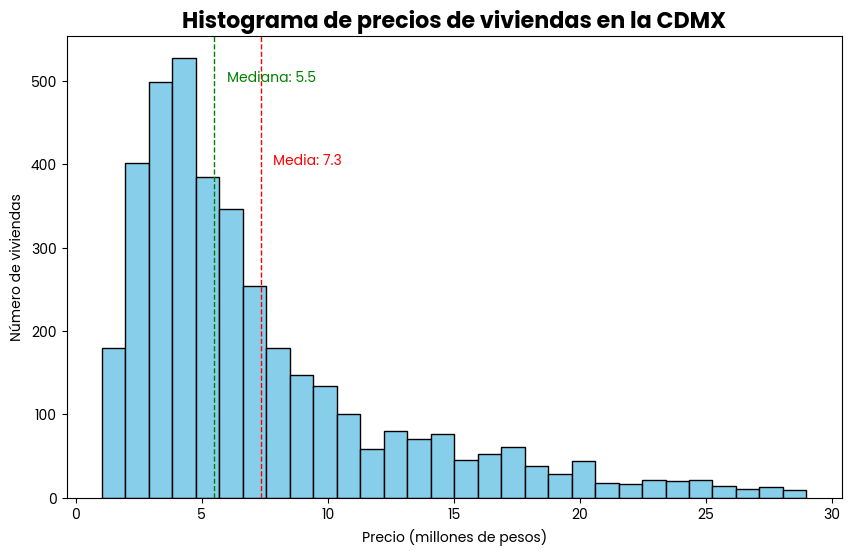

In [120]:
#Histograma de precios en millones en la CDMX
plt.figure(figsize=(10, 6))
plt.hist(df_limpia['precio'] / 1000000, bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma de precios de viviendas en la CDMX", fontsize=16, fontweight='bold')
plt.xlabel("Precio (millones de pesos)")
plt.ylabel("Número de viviendas")
#Añadir línea de la media
plt.axvline(df_limpia['precio'].mean() / 1000000, color='red', linestyle='dashed', linewidth=1)
#Añadir label de la media
plt.text(df_limpia['precio'].mean() / 1000000 + 0.5, 400, f"Media: {round(df_limpia['precio'].mean() / 1000000, 1)}", color='red')
#Mediana
plt.axvline(df_limpia['precio'].median() / 1000000, color='green', linestyle='dashed', linewidth=1)
plt.text(df_limpia['precio'].median() / 1000000 + 0.5, 500, f"Mediana: {round(df_limpia['precio'].median() / 1000000, 1)}", color='green')

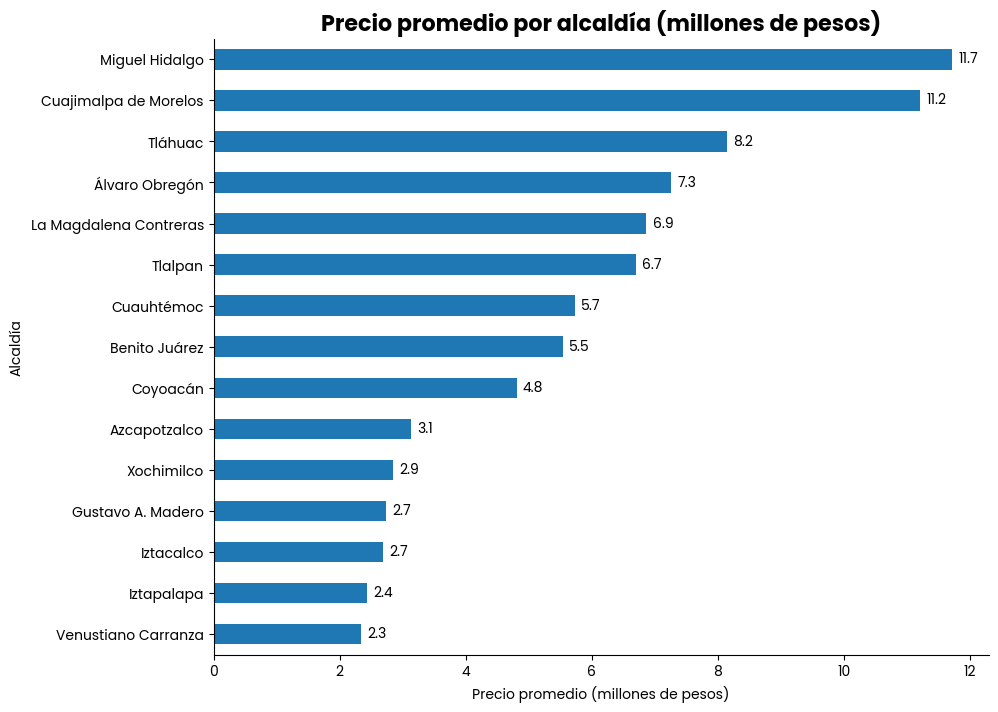

In [109]:
#Fuente montserrat
plt.rcParams['font.family'] = 'Poppins'
# Calculate the average price by borough and divide by 1 million for representation in millions of pesos
avg_price_per_borough = df_limpia.groupby('nomgeo')['precio'].mean() / 1000000

# Sort values for better visualization
avg_price_sorted = avg_price_per_borough.sort_values()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data
avg_price_sorted.plot(kind='barh', ax=ax)

# Set the title and labels
ax.set_title("Precio promedio por alcaldía (millones de pesos)", fontsize=16, fontweight='bold')
ax.set_xlabel("Precio promedio (millones de pesos)")
ax.set_ylabel("Alcaldía")

# Format the x-axis to show numbers with commas (e.g., 1,000 instead of 1000)
# And multiply the x-ticks by 1 million to adjust for the division we did earlier
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add value labels to each bar
for index, value in enumerate(avg_price_sorted):
    # Adjust text placement here
    ax.text(value + 0.1, index, f"{round(value, 1)}", va='center', ha='left', fontsize=10)
#Eliminar marco izquierdo y superior
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<Axes: ylabel='nomgeo'>

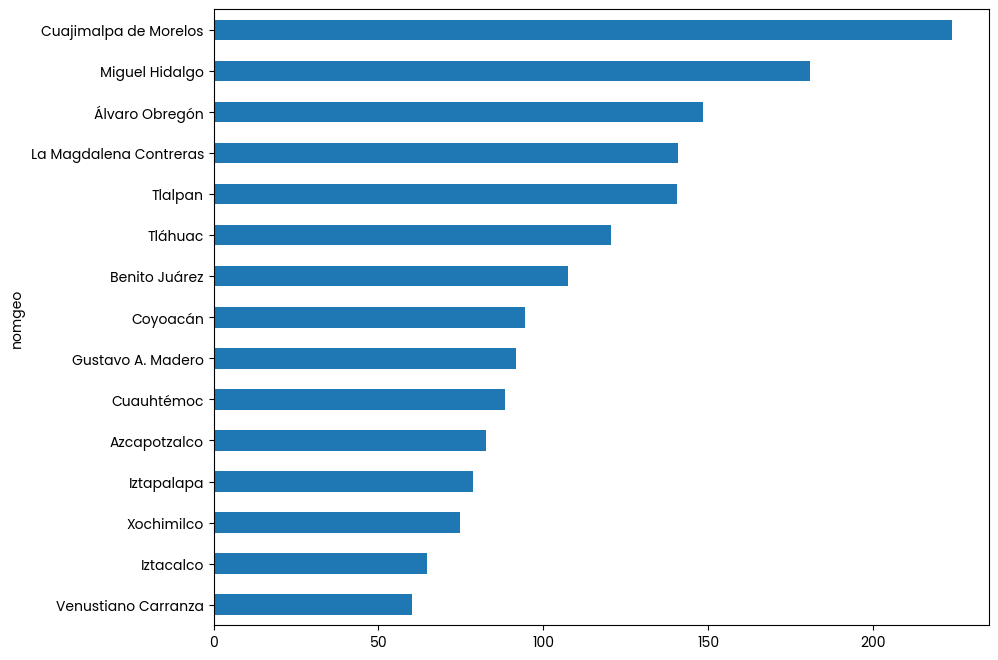

In [110]:
#Metros por alcaldía
metros_por_alcaldia = df_limpia.groupby('nomgeo')['mts_const'].mean()

# Sort values for better visualization
metros_sorted = metros_por_alcaldia.sort_values()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data
metros_sorted.plot(kind='barh', ax=ax)
